# Notebook Brief

# Load File

In [1]:
import zipfile
import os
import io
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from datetime import datetime

In [2]:
# This is how we upload the data we have
# path to the zip file that contains 35 geojson files
# each of which consists of daily reports of crime
zip_file_path = './24hrs.zip' 

# using the zipfile module we initiate a ZipFile object to read our zip file contents
# this object contains functions like .namelist() that will allow us to interact with the zip file contents
zip_ref = zipfile.ZipFile(zip_file_path,'r')

dataframes = [] # will store all geo data frames here
for filename in zip_ref.namelist():
    geojson = gpd.read_file(io.BytesIO(zip_ref.read(filename)))
    dataframes.append(geojson)
    

In [3]:
def merge(list_of_geodataframes):
    MERGEDALL = gpd.pd.concat(list_of_geodataframes,ignore_index = True)
    return MERGEDALL

One file contains every day from 2023. We will merge it with what we have from 2024. It was not part of the zip file.

In [4]:
# The file's name is TOPS 365days Jan3
# This time all we need is the path of the file
file_path = '../../dataset/TOPS 365days Jan 3.geojson'
file_path

'../../dataset/TOPS 365days Jan 3.geojson'

In [5]:
# Convert it to geo data frame
gdf_2023 = gpd.read_file(file_path)


In [6]:
# Append the 2023 data to the current list
# In fact insert to the beginning
dataframes.insert(0,gdf_2023)

In [7]:
# All of them are in this list now
len(dataframes)

36

In [8]:
# Merge all of them to make one giant geo data frame
MERGEDALL = merge(dataframes)

## Removing Duplicates

In [9]:
duplicates = MERGEDALL.duplicated()
MERGEDALL[duplicates]

,CREATE_TIME_INCIDENT,LOCATION_TEXT,BEAT,REPORT_NUMBER,LEGEND2,DISPO_TEXT,OBJECTID,geometry
151046,2024-01-06 19:27:17,None,NE1,None,159,MISC SERVICE CALL,303,POINT (-9375426.63790 3578494.57520)
156172,2024-01-21 16:59:00,FOUR OAKS PARK,9,None,505,COMMUNITY POLICING,281,POINT (-9376032.03670 3552614.50580)
156173,2024-01-21 17:09:05,DOLLAR GENERAL,11,None,505,COMMUNITY POLICING,282,POINT (-9384451.08090 3557823.05850)
157703,2024-01-27 09:09:31,RUEDIGER ELEMENTARY SCHOOL,15,None,505,COMMUNITY POLICING,1,POINT (-9382956.09570 3563054.36450)
157704,2024-01-27 03:42:28,GOOD SAMARITAN ACADEMY,9,None,505,COMMUNITY POLICING,2,POINT (-9377140.43270 3554561.34980)
...,...,...,...,...,...,...,...,...
161193,2024-01-28 13:47:23,AENON BAPTIST CHURCH,SW1,None,505,COMMUNITY POLICING,331,POINT (-9393031.19420 3559657.23630)
161194,2024-01-28 20:29:36,AMAZON FULFILLMENT CENTER,NE4,None,505,COMMUNITY POLICING,332,POINT (-9369634.07030 3566571.91980)
161195,2024-01-28 20:31:11,None,SE2,None,152,SUSPICIOUS,333,POINT (-9366706.13170 3555347.64320)
161196,2024-01-28 20:36:09,None,SW3,None,159,MISC SERVICE CALL,334,POINT (-9382658.75470 3553705.96660)


We will drop the duplicates

In [10]:
DF = MERGEDALL.drop_duplicates()

# Histogram Functions

We will define histogram functions that will display histograms for daily, weekly and montly bins.

In [11]:
def HistogramMonthly(DataFrame):
    create_time_incident = DataFrame.columns[0] #This should be the Create Time Incident Column
    date_counts = DataFrame[create_time_incident].dt.date.value_counts() #Returns a series of time incident <--> number of occurences
    date_counts_sorted = date_counts.sort_index()#sorts it with respect to date
   # Convert the index to datetime to ensure proper grouping
    date_counts_sorted.index = pd.to_datetime(date_counts_sorted.index)
    # Group by year and month, and sum the counts for each month
    monthly_counts = date_counts_sorted.groupby([date_counts_sorted.index.year, date_counts_sorted.index.month]).sum()

    # Plotting the histogram with monthly bins
    monthly_counts.plot(kind='bar', figsize=(15, 7))

    plt.title('Number of Incidents per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)  # Rotate the x-axis labels to show them more clearly
    plt.tight_layout()  # Adjust the layout so everything fits without overlapping

    # plt.show()

    

In [12]:
def HistogramWeekly(DataFrame):
    create_time_incident = DataFrame.columns[0]  # This should be the Create Time Incident Column
    date_counts = DataFrame[create_time_incident].dt.date.value_counts()  # Returns a series of time incident <--> number of occurrences
    date_counts_sorted = date_counts.sort_index()  # sorts it with respect to date
    
    # Convert the index to datetime to ensure proper grouping
    date_counts_sorted.index = pd.to_datetime(date_counts_sorted.index)
    
    # Group by year and week, and sum the counts for each week
    weekly_counts = date_counts_sorted.resample('W').sum()
    
    # Plotting the histogram with weekly bins
    weekly_counts.plot(kind='bar', figsize=(15, 7))
    
    plt.title('Number of Incidents per Week')
    plt.xlabel('Week')
    plt.ylabel('Number of Incidents')
    plt.xticks(rotation=45)  # Rotate the x-axis labels to show them more clearly
    plt.tight_layout()  # Adjust the layout so everything fits without overlapping
    
    # plt.show()

# Now you can call this function passing any DataFrame that has a datetime column as the first column
# For example:
# HistogramWeekly(gdf[34])


In [13]:
def HistogramDaily(DataFrame):
    create_time_incident = DataFrame.columns[0]  # This should be the Create Time Incident Column
    date_counts = DataFrame[create_time_incident].dt.date.value_counts()  # Returns a series of time incident <--> number of occurrences
    date_counts_sorted = date_counts.sort_index()  # sorts it with respect to date
    
    # Convert the index to datetime to ensure proper grouping
    date_counts_sorted.index = pd.to_datetime(date_counts_sorted.index)
    
    # Group by day and sum the counts for each day
    daily_counts = date_counts_sorted.resample('D').sum()
    
    # Plotting the histogram with daily bins
    daily_counts.plot(kind='bar', figsize=(15, 7))
    
    plt.title('Number of Incidents per Day')
    plt.xlabel('Day')
    plt.ylabel('Number of Incidents')
    plt.xticks([])  # Remove x-axis labels to avoid clutter
    plt.tight_layout()  # Adjust the layout so everything fits without overlapping
    
    # plt.show()

# You would call this function with a DataFrame like so:
# HistogramDaily(gdfs[35])


# Filter the Data: Remove Unwanted Categories and Locations

In [14]:
unwanted_locations = ['LEON CO DETENTION FACILITY', 'TALLAHASSEE POLICE DEPARTMENT', 'LCSO', 'TPD', 'LEON CO SHERIFFS OFFICE', 'IMMIGRATION & CUSTOMS ENFORCEM']

In [15]:
location_filtered_df = DF[~DF['LOCATION_TEXT'].isin(unwanted_locations)]

In [16]:
unwanted_categories = ["COMMUNITY POLICING", "ADMIN", "RECOVERED PROP", "AUTO THEFT RECOVERY","UNABLE TO VERIFY", "TRAFFIC"]

In [17]:
# Applying both filters
final_filtered_df = location_filtered_df[~location_filtered_df['DISPO_TEXT'].isin(unwanted_categories)]
final_filtered_df

,CREATE_TIME_INCIDENT,LOCATION_TEXT,BEAT,REPORT_NUMBER,LEGEND2,DISPO_TEXT,OBJECTID,geometry
0,2023-11-10 21:12:47,None,18,2023-00196053,122,DISORDERLY INTOXICATION,1,POINT (-9386627.75200 3565111.39140)
1,2023-08-31 01:41:41,None,17,None,152,SUSPICIOUS,2,POINT (-9388266.65440 3561752.12860)
2,2023-08-01 16:23:09,None,4,2023-00132523,104,AUTO THEFT,3,POINT (-9376397.42740 3566294.16600)
3,2023-09-01 00:20:51,PLANTATION CONDOS,14,None,152,SUSPICIOUS,4,POINT (-9386699.50640 3560238.44430)
4,2023-09-29 17:56:38,None,8,2023-00170694,302,CRASH WITH INJURIES,5,POINT (-9376069.55250 3558656.45000)
...,...,...,...,...,...,...,...,...
158390,2024-01-28 21:58:47,CIRCLE K,1,2024-00016372,146,THEFT - PETIT,324,POINT (-9378627.68330 3569037.40910)
158391,2024-01-29 00:55:42,CIRCLE K,17,None,152,SUSPICIOUS,325,POINT (-9391746.53840 3562502.38510)
158393,2024-01-29 01:01:33,MCDONALDS,15,None,152,SUSPICIOUS,327,POINT (-9383527.14910 3560893.23170)
158399,2024-01-28 20:31:11,None,SE2,None,152,SUSPICIOUS,333,POINT (-9366706.13170 3555347.64320)


In [18]:
df = final_filtered_df.copy()

# Introductory Analysis

## Monthly

In [19]:
CTI = df['CREATE_TIME_INCIDENT'].dt.date.value_counts().sort_index()
CTI

CREATE_TIME_INCIDENT
2023-01-02     14
2023-01-03    234
2023-01-04    190
2023-01-05    241
2023-01-06    252
             ... 
2024-01-25    232
2024-01-26    306
2024-01-27    183
2024-01-28    171
2024-01-29     28
Name: count, Length: 393, dtype: int64

Number of incidents on average per month

In [20]:
CTI.index = pd.to_datetime(CTI.index) # This is needed to use resample method allowing us to resample dates by the day, week or month, year etc.
Monthly_CTI = CTI.resample('M').sum()
Monthly_mean = int(np.mean(Monthly_CTI)) #check the mean
Monthly_mean

7311

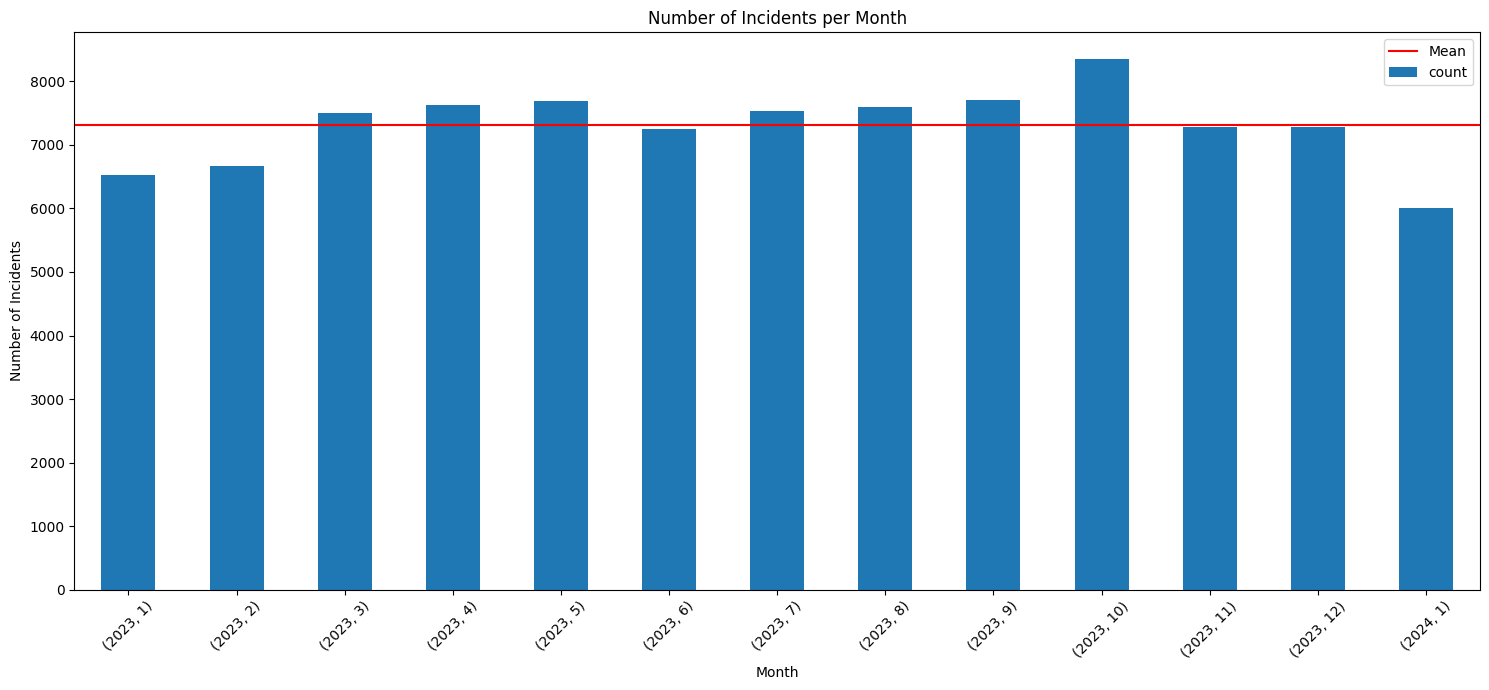

In [21]:
# Number of incidents occured per month
HistogramMonthly(df)
plt.axhline(y = Monthly_mean,color='r',label='Mean')
plt.legend()
plt.show()

## Seasonal

Assigning Spring Semester: 2023-01-09 to 2023-05-05, count: 28324
Assigning Summer: 2023-05-06 to 2023-08-27, count: 27718
Assigning Fall Semester: 2023-08-28 to 2023-12-15, count: 28081
Academic_Period
Spring Semester    28324
Fall Semester      28081
Summer             27718
Name: count, dtype: int64


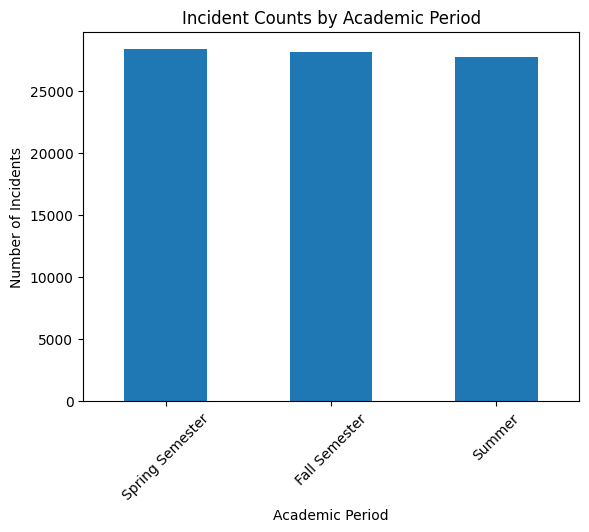

In [22]:
periods = {
    'Spring Semester': ('2023-01-09', '2023-05-05'),  # Assuming Spring ends on May 5th
    'Summer': ('2023-05-06', '2023-08-27'),  # Summer period
    'Fall Semester': ('2023-08-28', '2023-12-15'),  # Assuming Fall starts on Aug 28th
}
# 'Spring Break': ('2023-03-13', '2023-03-17') # Add this to periods list if you want to display spring break

# Ensure CREATE_TIME_INCIDENT is a datetime
df['CREATE_TIME_INCIDENT'] = pd.to_datetime(df['CREATE_TIME_INCIDENT'])

# Initialize a new column for the academic period directly in the DataFrame
df['Academic_Period'] = pd.NA

for period, (start, end) in periods.items():
    start_date = pd.to_datetime(start).date()
    end_date = pd.to_datetime(end).date()
    mask = df['CREATE_TIME_INCIDENT'].dt.date.between(start_date, end_date)
    print(f"Assigning {period}: {start_date} to {end_date}, count: {mask.sum()}")  # Diagnostic print
    df.loc[mask, 'Academic_Period'] = period

# After this point, df should have 'Academic_Period' properly assigned.
# Check the final counts to ensure all periods are represented
incident_counts = df['Academic_Period'].value_counts()
print(incident_counts)  # Diagnostic print to check if Fall Semester is present

# Proceed with plotting
incident_counts.plot(kind='bar')
plt.title('Incident Counts by Academic Period')
plt.xlabel('Academic Period')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()


# Bar Chart for the Total # of Crimes At Each Hour Across All Data Points

We would like study all our dataset by the hour. That is, look at the number of incidents that occur each hour of the day across all dates.

In [23]:
# Look at the number of incidents each hour of the day
# 0 = First hour of

hourly_incidents = df['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()
hourly_incidents

CREATE_TIME_INCIDENT
0     3613
1     3053
2     2820
3     2225
4     1544
5     1324
6     1528
7     2567
8     3516
9     3999
10    4673
11    4879
12    5119
13    5245
14    5261
15    5147
16    5453
17    5407
18    5162
19    4866
20    4674
21    4417
22    4517
23    4039
Name: count, dtype: int64

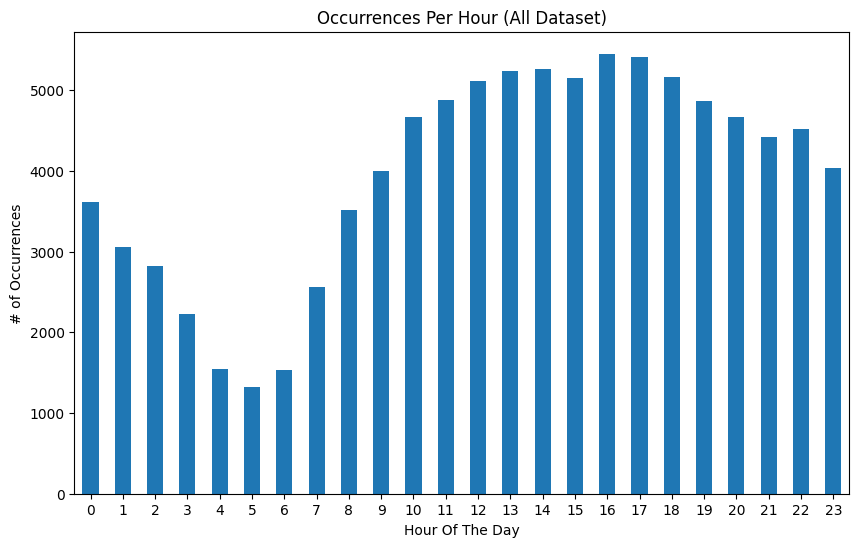

In [29]:
hourly_incidents.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (All Dataset)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()

# Bar Chart for the Total # of Crimes At Different Partitions of the Day Across All Data Points

## Quarter Partition (Every Six-Hour)

Rather than looking at the hour of the day across all data points, we will divide a day up into quarters. Namely,

1. 12:00am - 5:59am --- First Quarter
2. 6:00am - 11:59am --- Second Quarter
3. 12:00pm - 5:59pm --- Third Quarter
4. 6pm - 11:59pm --- Fourth Quarter

In [61]:
hours = df['CREATE_TIME_INCIDENT'].dt.hour
quarters = (hours//6) + 1 # Mapping of the hours to quarters: e.g. Hour 8 will be mapped to 2 since it belongs to the 2nd quarter of the day

In [67]:
quarters_counts = quarters.value_counts().sort_index()

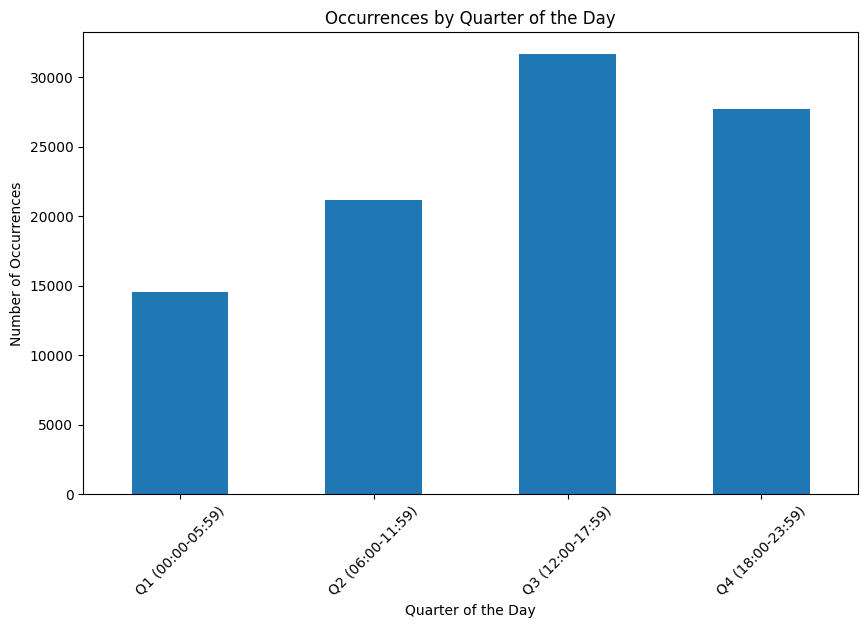

In [68]:
quarters_counts.plot(kind = 'bar', figsize = (10,6))
plt.title('Occurrences by Quarter of the Day')
plt.xlabel('Quarter of the Day')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Q1 (00:00-05:59)', 'Q2 (06:00-11:59)', 'Q3 (12:00-17:59)', 'Q4 (18:00-23:59)'], rotation=45)
plt.show()

## Every Four-Hour

In [69]:
hours = df['CREATE_TIME_INCIDENT'].dt.hour
four_hour_partition = (hours//4) + 1 # Mapping of the hours to every 4 hour partition:
#e.g. Hour 5 will be mapped to 2 since it belongs to the 2nd four-hour of the day


In [71]:
four_hour_partition_counts = four_hour_partition.value_counts().sort_index()

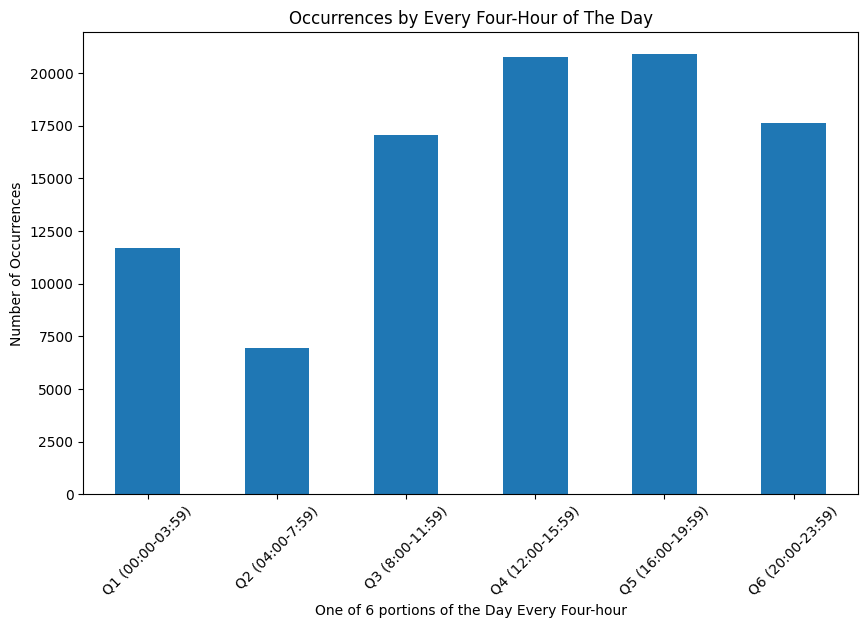

In [72]:
four_hour_partition_counts.plot(kind = 'bar', figsize = (10,6))
plt.title('Occurrences by Every Four-Hour of The Day')
plt.xlabel('One of 6 portions of the Day Every Four-hour')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Q1 (00:00-03:59)', 'Q2 (04:00-7:59)', 'Q3 (8:00-11:59)', 'Q4 (12:00-15:59)','Q5 (16:00-19:59)','Q6 (20:00-23:59)'], rotation=45)
plt.show()

## Every Three - Hour

In [73]:
hours = df['CREATE_TIME_INCIDENT'].dt.hour
three_hour_partition = (hours//3) + 1 # Mapping of the hours to every 4 hour partition:
#e.g. Hour 8 will be mapped to 3 since it belongs to the 3rd three-hour of the day


In [74]:
three_hour_partition_counts = three_hour_partition.value_counts().sort_index()

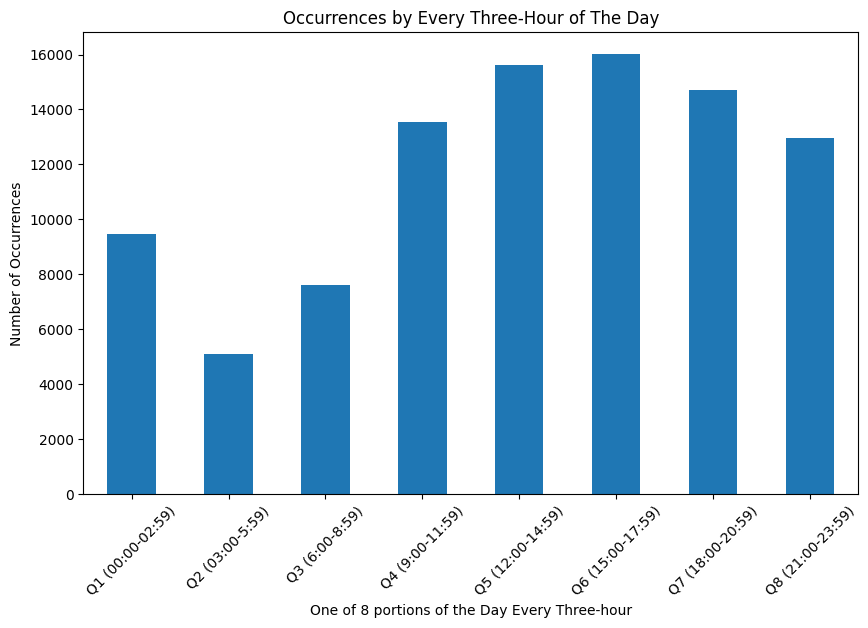

In [75]:
three_hour_partition_counts.plot(kind = 'bar', figsize = (10,6))
plt.title('Occurrences by Every Three-Hour of The Day')
plt.xlabel('One of 8 portions of the Day Every Three-hour')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7], labels=['Q1 (00:00-02:59)', 'Q2 (03:00-5:59)', 'Q3 (6:00-8:59)', 
                                                   
                                                   'Q4 (9:00-11:59)','Q5 (12:00-14:59)','Q6 (15:00-17:59)',
                                                   'Q7 (18:00-20:59)','Q8 (21:00-23:59)'], rotation=45)
plt.show()

## Every Two - Hour

In [76]:
hours = df['CREATE_TIME_INCIDENT'].dt.hour
two_hour_partition = (hours//2) + 1 # Mapping of the hours to every 4 hour partition:
#e.g. Hour 3 will be mapped to 2 since it belongs to the 2nd three-hour of the day


In [77]:
two_hour_partition_counts = two_hour_partition.value_counts().sort_index()

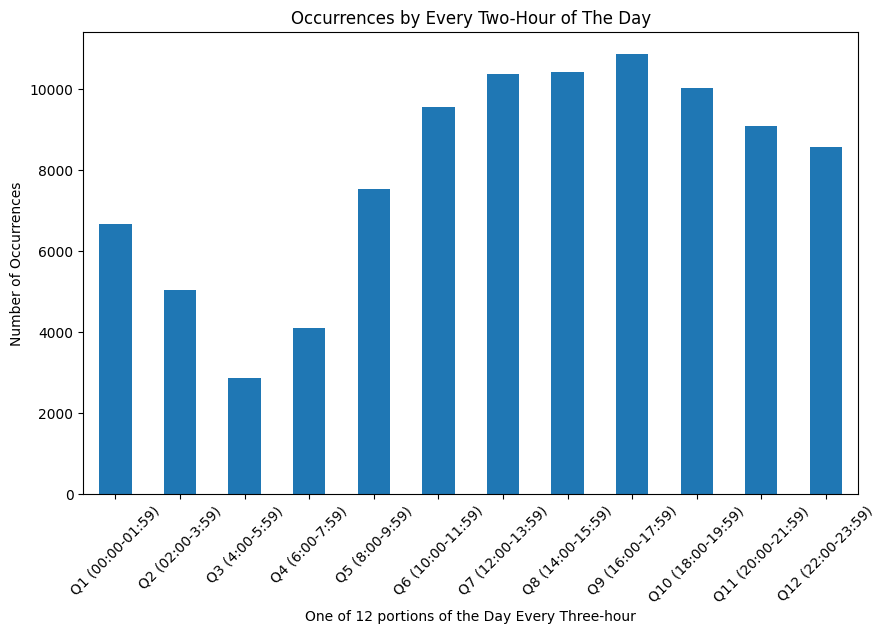

In [84]:
two_hour_partition_counts.plot(kind = 'bar', figsize = (10,6))
plt.title('Occurrences by Every Two-Hour of The Day')
plt.xlabel('One of 12 portions of the Day Every Three-hour')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7,8,9,10,11], labels=['Q1 (00:00-01:59)', 'Q2 (02:00-3:59)', 'Q3 (4:00-5:59)', 
                                                   
                                                   'Q4 (6:00-7:59)','Q5 (8:00-9:59)','Q6 (10:00-11:59)',
                                                   'Q7 (12:00-13:59)','Q8 (14:00-15:59)',
                                                  'Q9 (16:00-17:59)',
                                                  'Q10 (18:00-19:59)',
                                                  'Q11 (20:00-21:59)','Q12 (22:00-23:59)',
                                                  ], rotation=45)
plt.show()

## Am & Pm (Every Twelve - Hour)

In [86]:
hours = df['CREATE_TIME_INCIDENT'].dt.hour
am_pm_partition = (hours//12) + 1 # Mapping of the hours to every 4 hour partition:
#e.g. Hour 13 will be mapped to 2 since it belongs to the 2nd part of the day


In [87]:
am_pm_partition_counts = am_pm_partition.value_counts().sort_index()

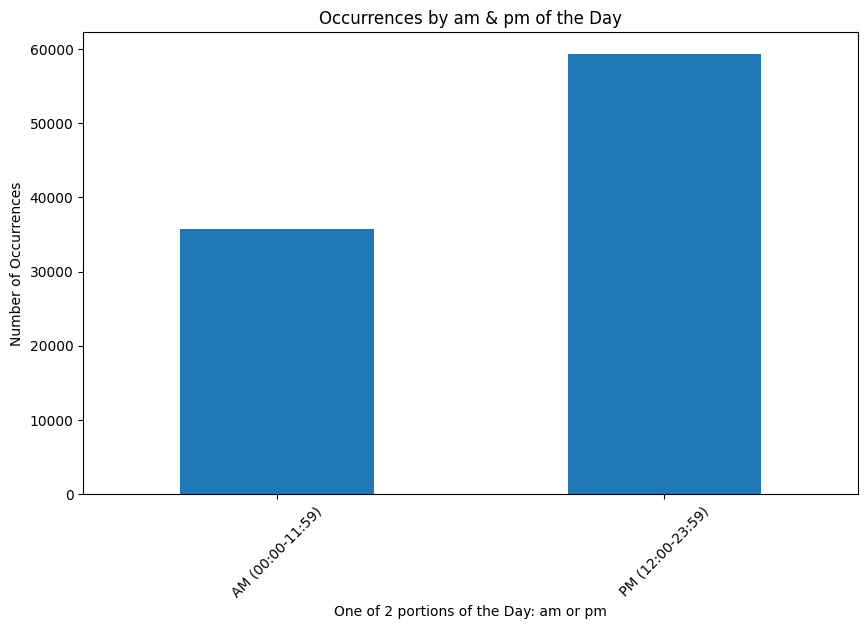

In [89]:
am_pm_partition_counts.plot(kind = 'bar', figsize = (10,6))
plt.title('Occurrences by am & pm of the Day')
plt.xlabel('One of 2 portions of the Day: am or pm')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1], labels=['AM (00:00-11:59)', 'PM (12:00-23:59)'
                                                  ], rotation=45)
plt.show()

## Daylight & Night

I will assume that the daylight hours are 7am to 7pm although it varies each season.

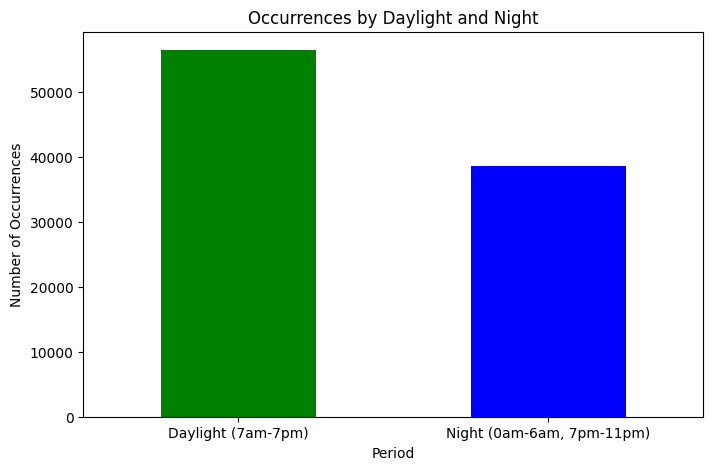

In [93]:
# Define a function that maps hours to 0 or 1 depending on whether there are in the daylight hours or night: Daylight == 0 , Night == 1
def map_hour_to_period(hour):
    if 0 <= hour <= 6 or 19 <= hour <= 23:
        return 1  # Night
    else:
        return 0  # Daylight

# Apply the function to each hour in the series
mapped_hours = df['CREATE_TIME_INCIDENT'].dt.hour.apply(map_hour_to_period)

# Count the number of occurrences of each period (0 or 1)
period_counts = mapped_hours.value_counts()

# Sort the index to ensure periods are in order (optional, for clarity)
period_counts = period_counts.sort_index()

# Plotting
period_counts.plot(kind='bar', figsize=(8, 5), color=['green', 'blue'])

plt.title('Occurrences by Daylight and Night')
plt.xlabel('Period')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1], labels=['Daylight (7am-7pm)', 'Night (0am-6am, 7pm-11pm)'], rotation=0)

plt.show()


# Do We See the Same Trend With Different Portions of The Data?

Recall that we had the following hourly trend across all data points.

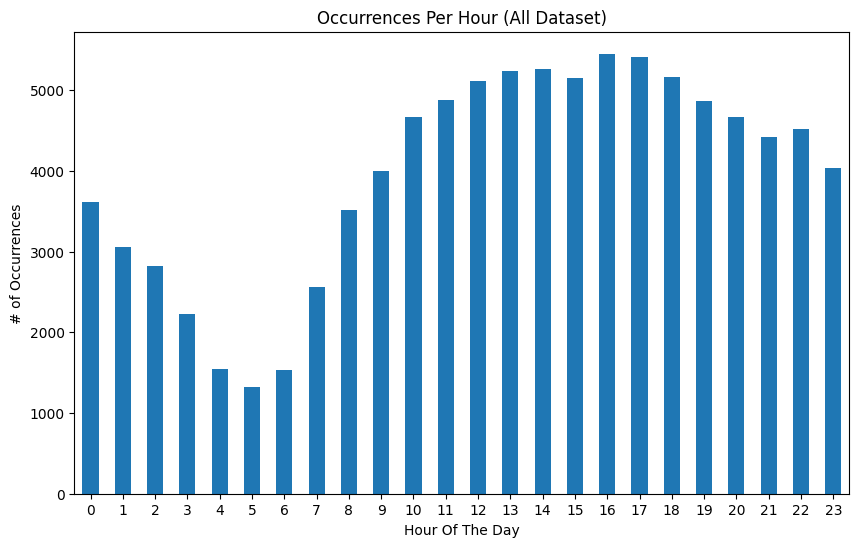

In [96]:
hourly_incidents.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (All Dataset)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()

What if we do the same analysis on different seasons: winter, spring, summer and fall.

## Seasonal Data

First we will only work with the 2023 data.

In [118]:
get_2023_index = df['CREATE_TIME_INCIDENT'].dt.year == 2023

In [119]:
df_2023 = df[get_2023_index].copy()

In [127]:
df_2023['CREATE_TIME_INCIDENT']

0        2023-11-10 21:12:47
1        2023-08-31 01:41:41
2        2023-08-01 16:23:09
3        2023-09-01 00:20:51
4        2023-09-29 17:56:38
                 ...        
149205   2023-12-26 16:32:21
149206   2023-12-26 16:38:28
149208   2023-12-26 19:47:27
149213   2023-12-26 14:14:51
149214   2023-12-26 19:11:29
Name: CREATE_TIME_INCIDENT, Length: 89042, dtype: datetime64[ns]

In [131]:
months = df_2023['CREATE_TIME_INCIDENT'].dt.month
months

0         11
1          8
2          8
3          9
4          9
          ..
149205    12
149206    12
149208    12
149213    12
149214    12
Name: CREATE_TIME_INCIDENT, Length: 89042, dtype: int32

We will map each month to its season. e.g. 4 (April) will be mapped to 2 (Spring).

For reference,

* Winter = 0
* Spring = 1
* Summer = 2
* Fall = 3

In [152]:
seasons = (months//3)%4

In [153]:
seasons

0         3
1         2
2         2
3         3
4         3
         ..
149205    0
149206    0
149208    0
149213    0
149214    0
Name: CREATE_TIME_INCIDENT, Length: 89042, dtype: int32

While we have the incidents per season counted, we could plot a bar chart for this before we look at hourly analysis for different seasons.

In [157]:
seasons_count = seasons.value_counts().sort_index()

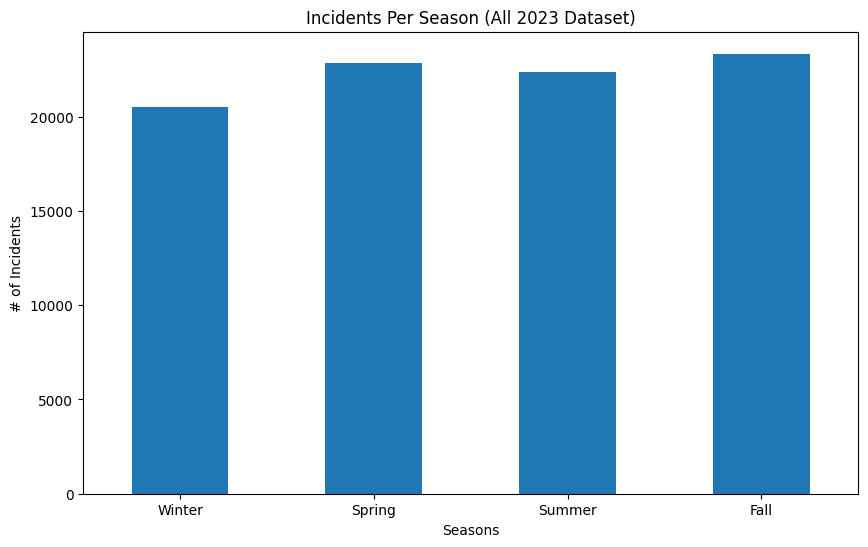

In [159]:
seasons_count.plot(kind = 'bar',figsize = (10,6))
plt.title('Incidents Per Season (All 2023 Dataset)')
plt.xlabel('Seasons')
plt.ylabel('# of Incidents')
plt.xticks(ticks=[0, 1,2,3], labels=['Winter', 'Spring','Summer','Fall'], rotation=0)

plt.show()

### Winter Data

In [167]:
winter_2023 = df_2023[seasons == 0].copy()
winter_2023

,CREATE_TIME_INCIDENT,LOCATION_TEXT,BEAT,REPORT_NUMBER,LEGEND2,DISPO_TEXT,OBJECTID,geometry,Academic_Period
6,2023-12-20 19:57:41,None,14,None,152,SUSPICIOUS,7,POINT (-9387122.72080 3560363.98800),<NA>
9,2023-02-21 12:16:55,None,SW1,None,152,SUSPICIOUS,10,POINT (-9396859.99580 3559363.64380),Spring Semester
11,2023-02-21 15:48:02,None,SE1,None,159,MISC SERVICE CALL,12,POINT (-9374768.57940 3546073.18790),Spring Semester
13,2023-02-21 18:44:10,TALLAHASSEE MENS CENTER,SE2,None,148,TRESPASS WARNING,14,POINT (-9372447.22070 3558685.24460),Spring Semester
17,2023-02-21 20:47:35,None,SW1,None,159,MISC SERVICE CALL,18,POINT (-9420673.31100 3553898.87340),Spring Semester
...,...,...,...,...,...,...,...,...,...
149205,2023-12-26 16:32:21,EVERGREENS AT MAHAN APTS,6,None,159,MISC SERVICE CALL,149206,POINT (-9377109.67950 3562229.97840),NaN
149206,2023-12-26 16:38:28,None,6,None,159,MISC SERVICE CALL,149207,POINT (-9375633.24020 3562987.91650),NaN
149208,2023-12-26 19:47:27,2305 AT KILLEARN APTS,2,None,133,LOUD NOISE / MUSIC,149209,POINT (-9377809.96600 3568400.03380),NaN
149213,2023-12-26 14:14:51,None,NE1,None,159,MISC SERVICE CALL,149214,POINT (-9366901.03320 3576978.28410),NaN


In [168]:
# Look at the number of incidents each hour of the day
# 0 = First hour of
hourly_incidents_winter2023 = winter_2023['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()
hourly_incidents_winter2023

CREATE_TIME_INCIDENT
0      737
1      644
2      640
3      510
4      306
5      259
6      341
7      543
8      741
9      830
10    1039
11    1040
12    1088
13    1139
14    1209
15    1178
16    1167
17    1203
18    1168
19    1025
20     960
21     910
22     938
23     878
Name: count, dtype: int64

It seems (perhaps not surprisingly) we see the same trend by the hour

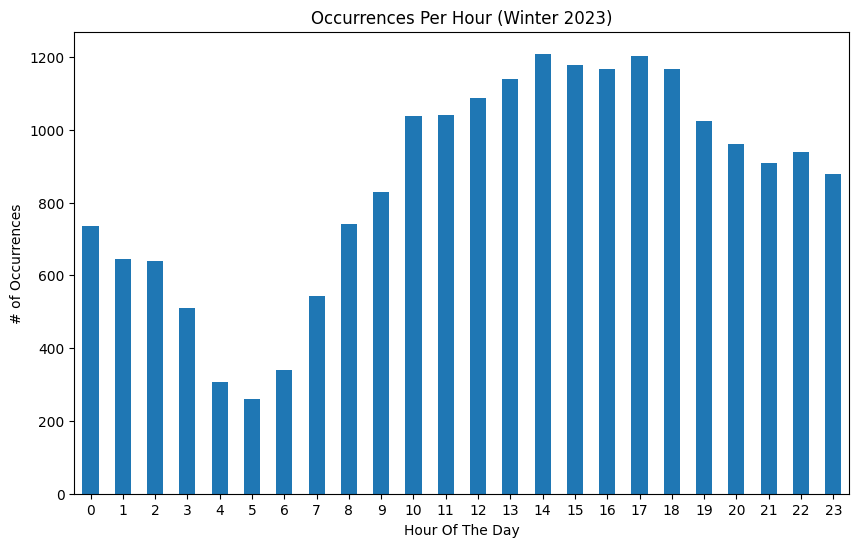

In [170]:
hourly_incidents_winter2023.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (Winter 2023)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()

### Spring Data

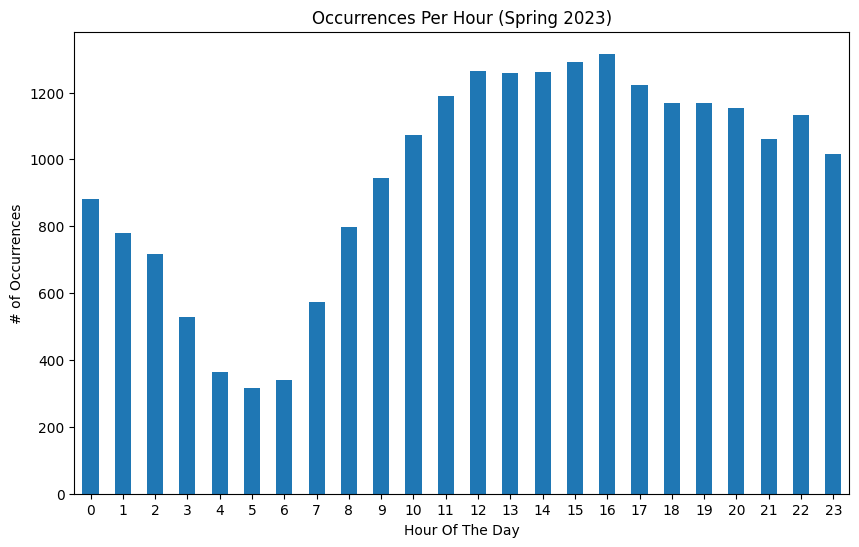

In [171]:
# Define the seasonal data
spring_2023 = df_2023[seasons == 1].copy()
hourly_incidents_spring2023 = spring_2023['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()

## Plot
hourly_incidents_spring2023.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (Spring 2023)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()


### Summer Data

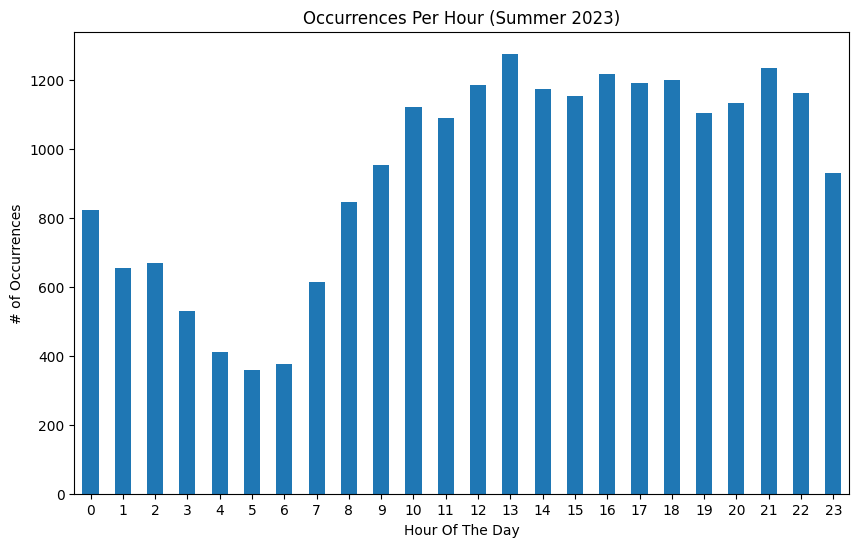

In [172]:
# Define the seasonal data
summer_2023 = df_2023[seasons == 2].copy()
hourly_incidents_summer2023 = summer_2023['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()

## Plot
hourly_incidents_summer2023.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (Summer 2023)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()


### Fall Data

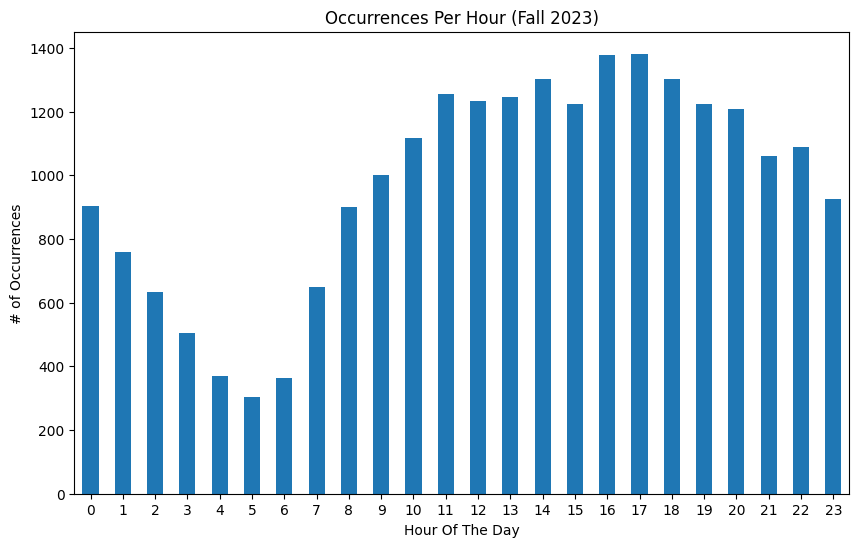

In [175]:
# Define the seasonal data
fall_2023 = df_2023[seasons == 3].copy()
hourly_incidents_fall2023 = fall_2023['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()

## Plot
hourly_incidents_fall2023.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Hour (Fall 2023)')
plt.xlabel('Hour Of The Day')
plt.ylabel('# of Occurrences')
plt.xticks(rotation = 0)
plt.show()


# Analysis by Academic Period (With Dorms open and closing)

In [226]:
from datetime import date

In [245]:
df_2023['CREATE_TIME_INCIDENT'] = pd.to_datetime(df_2023['CREATE_TIME_INCIDENT']).dt.date

# Define your start and end dates of spring semester
# According to when the residents hall open and close
start_date_spring = pd.to_datetime('2023-01-05').date()
end_date_spring = pd.to_datetime('2023-05-06').date()
spring_semester_2023 = df_2023['CREATE_TIME_INCIDENT'].apply(lambda d: start_date_spring <= d <= end_date_spring)

In [246]:
# Define your start and end dates of fall semester
# According to when the residents hall open and close
start_date_fall = pd.to_datetime('2023-08-18').date()
end_date_fall = pd.to_datetime('2023-12-16').date()
fall_semester_2023 = df_2023['CREATE_TIME_INCIDENT'].apply(lambda d: start_date_fall <= d <= end_date_fall)

In [247]:
# Define your start and end dates of summer semester
# According to when the residents hall open and close
start_date_summer = pd.to_datetime('2023-05-11').date()
end_date_summer = pd.to_datetime('2023-08-05').date()
summer_semester_2023 = df_2023['CREATE_TIME_INCIDENT'].apply(lambda d: start_date_summer <= d <= end_date_summer)

In [257]:
incident_counts_by_semester = [len(spring_semester_2023),len(fall_semester_2023),len(summer_semester_2023)]

In [258]:
incident_counts_by_semester

[89042, 89042, 89042]

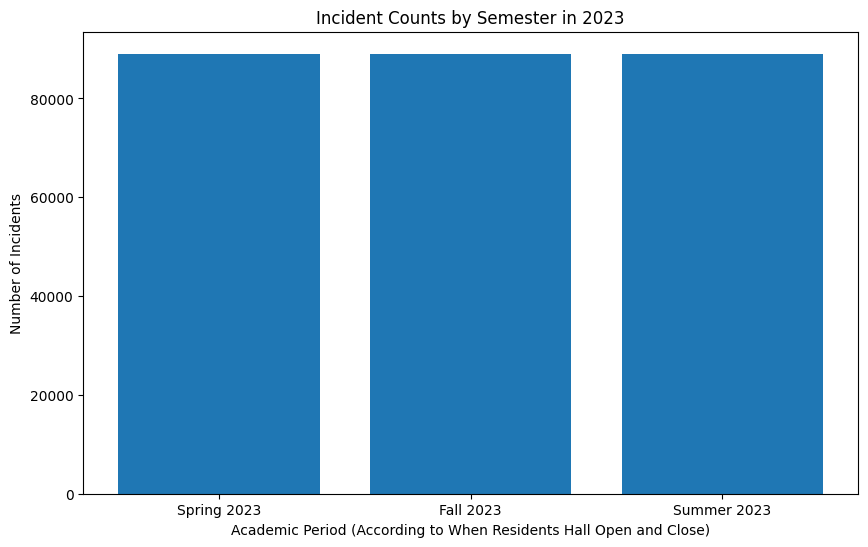

In [262]:
# Semesters
semesters = ['Spring 2023', 'Fall 2023', 'Summer 2023']

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(semesters, incident_counts_by_semester)

# Add a title and labels
plt.title('Incident Counts by Semester in 2023')
plt.xlabel('Academic Period (According to When Residents Hall Open and Close)')
plt.ylabel('Number of Incidents')

# Show the plot
plt.show()